**Purpose**: This notebook aims to capture the Great Flood of 1862. It was the largest recorded flood in the history of California, Nevada, and Oregon. It occurred following several weeks of continuous **rain and snow that began in Oregon in November of 1861 and continued into January 1862**. These weather conditions contributed to flooding that spanned from the Columbia River in western Oregon to the city of San Diego, over 1,000 miles away, and also impacted a handful of interior states. 

---

The CESM2 Large Ensemble uses a combination of different oceanic and atmospheric initial states to create ensemble spread as follows:

- Members 1-10: These begin from years 1001, 1021, 1041, 1061, 1081, 1101, 1121, 1141, 1161, and 1181 of the 1400-year pre-industrial control simulation. This segment of the control simulation was chosen to minimize drift.

- Members 11-90: These begin from 4 pre-selected years of the pre-industrial control simulation based on the phase of the Atlantic Meridional Overturning Circulation (AMOC). For each of the 4 initial states, there are 20 ensemble members created by randomly perturbing the atmospheric temperature field by order 10^-14K. The chosen start dates (model years 1231, 1251, 1281, and 1301) sample AMOC and Sea Surface Height (SSH) in the Labrador Sea at their maximum, minimum and transition states.

- Members 91-100: These begin from years 1011, 1031, 1051, 1071, 1091, 1111, 1131, 1151, 1171, and 1191 of the 1400-year pre-industrial control simulation. This set includes the extensive "MOAR" output, which can be used to drive regional climate models.

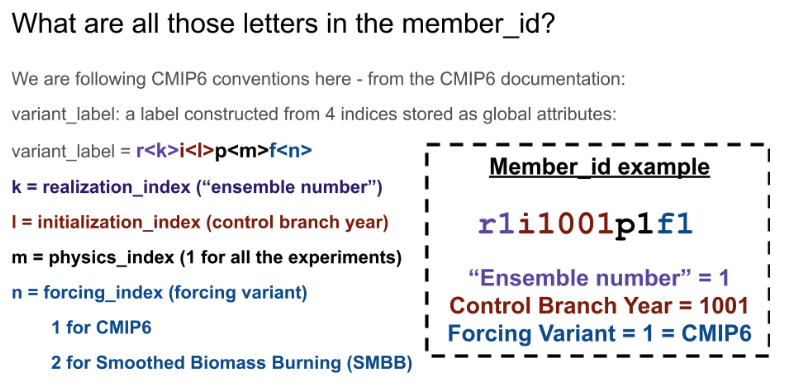

The initialization design allows assessment of oceanic (AMOC) and atmospheric contributions to ensemble spread, and the impact of AMOC initial-condition memory on the global earth system.

[Output Variable Documentation](https://www.cesm.ucar.edu/community-projects/lens2/output-variables) 

**Data Access**

The CESM2 Large Ensemble dataset can be accessed via:

- Direct HTTP access [UCAR Download](https://www.earthsystemgrid.org/dataset/ucar.cgd.cesm2le.output.html)

- Cloud Native: [Amazon Sustainability Data Initiative](https://aws.amazon.com/marketplace/pp/prodview-xilranwbl2ep2#usage)


In [36]:
import intake
import numpy as np
import geopandas as gpd
import rioxarray
from dask.distributed import Client
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

import pandas
import datetime


# helper functions
import helpers

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/castronova/proxy/8787/status,
Dashboard: /user/castronova/proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 30.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42217,Workers: 4
Dashboard: /user/castronova/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 30.00 GiB
Comm: tcp://127.0.0.1:38481,Total threads: 2
Dashboard: /user/castronova/proxy/41477/status,Memory: 7.50 GiB
Nanny: tcp://127.0.0.1:35645,


Load the CESM2 intake catalog and filter for daily rainfall.

In [37]:
# List the data available in the Intake Catalog
catalog = intake.open_esm_datastore(
    'https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json'
)

catalog_subset = catalog.search(variable='RAIN', frequency='daily')
catalog_subset.df

,variable,long_name,component,experiment,forcing_variant,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,RAIN,"atmospheric rain, after rain/snow repartitioni...",lnd,historical,cmip6,daily,1.0,global_land,mm/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/lnd/daily/cesm2LE-histori...
1,RAIN,"atmospheric rain, after rain/snow repartitioni...",lnd,historical,smbb,daily,1.0,global_land,mm/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/lnd/daily/cesm2LE-histori...
2,RAIN,"atmospheric rain, after rain/snow repartitioni...",lnd,ssp370,cmip6,daily,1.0,global_land,mm/s,2015-01-01 12:00:00,2100-12-31 12:00:00,s3://ncar-cesm2-lens/lnd/daily/cesm2LE-ssp370-...
3,RAIN,"atmospheric rain, after rain/snow repartitioni...",lnd,ssp370,smbb,daily,1.0,global_land,mm/s,2015-01-01 12:00:00,2100-12-31 12:00:00,s3://ncar-cesm2-lens/lnd/daily/cesm2LE-ssp370-...


In [38]:
# return a dictionary of the datasets in the catalog_subset
dsets = catalog_subset.to_dataset_dict(storage_options={'anon':True})

# load the historical cmip predictions
historical_cmip6 = dsets['lnd.historical.daily.cmip6']

# set the SRS
historical_cmip6.rio.write_crs("epsg:4326", inplace=True)
historical_cmip6.rio.set_spatial_dims('lon', 'lat')
historical_cmip6.rio.crs.to_wkt()

# convert the longitudes in our dataset from degrees-west into degrees ranging from -180 to 180 
# this is necessary so that they align properly with our vector data.
historical_cmip6['lon'] = historical_cmip6.lon - 180

historical_cmip6


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


<xarray.Dataset> Size: 533GB
Dimensions:      (member_id: 40, time: 60225, lat: 192, lon: 288,
                  hist_interval: 2)
Coordinates:
  * lat          (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon          (lon) float32 1kB -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * member_id    (member_id) <U12 2kB 'r10i1231p1f1' ... 'r9i1301p1f1'
  * time         (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
    time_bounds  (time, hist_interval) object 964kB dask.array<chunksize=(30113, 1), meta=np.ndarray>
    spatial_ref  int64 8B 0
Dimensions without coordinates: hist_interval
Data variables:
    RAIN         (member_id, time, lat, lon) float32 533GB dask.array<chunksize=(1, 730, 192, 288), meta=np.ndarray>
Attributes: (12/115)
    Conventions:                               CF-1.0
    Initial_conditions_dataset:                arbitrary initialization
    PFT_physiological_constants_dataset:       clm5_params.c171117.nc
    Surface_dataset:                           surfdata_0.9x1.25_hist_78pfts_...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...
    Time_constant_3Dvars_filename:             ./b.e21.BHISTcmip6.f09_g17.LE2...
    ...                                        ...
    intake_esm_attrs:units:                    mm/s
    intake_esm_attrs:start_time:               1850-01-01 12:00:00
    intake_esm_attrs:end_time:                 2014-12-31 12:00:00
    intake_esm_attrs:path:                     s3://ncar-cesm2-lens/lnd/daily...
    intake_esm_attrs:_data_format_:            zarr
    intake_esm_dataset_key:                    lnd.historical.daily.cmip6

## 2. Study Area

The study area for this analysis is California, however the rainfall that was the main driver for flooding is said to have occurred in western Oregon.


https://www.aonedge.com/Resource-Center/Blog/California-Great-Flood-of-1862 
>What Caused the Great Flood of 1862?
The Great Flood of 1862 was the largest recorded flood in the history of California, Nevada, and Oregon. It occurred following several weeks of continuous **rain and snow that began in Oregon in November of 1861 and continued into January 1862**.These weather conditions contributed to flooding that spanned from the Columbia River in western Oregon to the city of San Diego, over 1,000 miles away, and also impacted a handful of interior states. The devastation was widespread and in California:
>
>- 4,000 people died
>
>- 1/3 of property was destroyed
>
>- 200,000 heads of cattle, or 25% of the state’s total, wiped out
>
>- The state went bankrupt, with state employees unable to be paid for 18 months
>
>- Inflation saw the price of eggs rise to 3 dollars per dozen, or 79 dollars in today’s dollars
>
> 
>California state legislators had to row to work at the Capital in Sacramento for several weeks before temporarily relocating to San Francisco, so that much of the city could be raised on average 10 feet. You can still visit the “underground city” if you ever visit Old Town Sacramento.
 

Clip the CESM data to the our area of interest.

In [39]:
# Load the sample dataset of the USA states from geopandas
usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter the dataset for the USA
usa_states = usa[usa['iso_a3'] == 'USA']

# Load the US states from an online source
states_url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
states = gpd.read_file(states_url)
geom = states[states.name == 'Oregon']


# clip the data
cmip = historical_cmip6.rio.clip(
         geom.geometry.values,
         geom.crs,
         all_touched=True,   # select all grid cells that touch the vector boundary
         drop=True,          # drop anything that is outside the clipped region
         invert=False,
         from_disk=True)
cmip

/tmp/ipykernel_2060/723563209.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<xarray.Dataset> Size: 463MB
Dimensions:      (lat: 6, lon: 8, member_id: 40, time: 60225)
Coordinates:
  * lat          (lat) float32 24B 41.94 42.88 43.82 44.76 45.71 46.65
  * lon          (lon) float32 32B -125.0 -123.8 -122.5 ... -118.8 -117.5 -116.2
  * member_id    (member_id) <U12 2kB 'r10i1231p1f1' ... 'r9i1301p1f1'
  * time         (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
    spatial_ref  int64 8B 0
Data variables:
    RAIN         (member_id, time, lat, lon) float32 463MB dask.array<chunksize=(1, 730, 6, 8), meta=np.ndarray>
Attributes: (12/115)
    Conventions:                               CF-1.0
    Initial_conditions_dataset:                arbitrary initialization
    PFT_physiological_constants_dataset:       clm5_params.c171117.nc
    Surface_dataset:                           surfdata_0.9x1.25_hist_78pfts_...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...
    Time_constant_3Dvars_filename:             ./b.e21.BHISTcmip6.f09_g17.LE2...
    ...                                        ...
    intake_esm_attrs:units:                    mm/s
    intake_esm_attrs:start_time:               1850-01-01 12:00:00
    intake_esm_attrs:end_time:                 2014-12-31 12:00:00
    intake_esm_attrs:path:                     s3://ncar-cesm2-lens/lnd/daily...
    intake_esm_attrs:_data_format_:            zarr
    intake_esm_dataset_key:                    lnd.historical.daily.cmip6

Plot the extent of our data on a map.

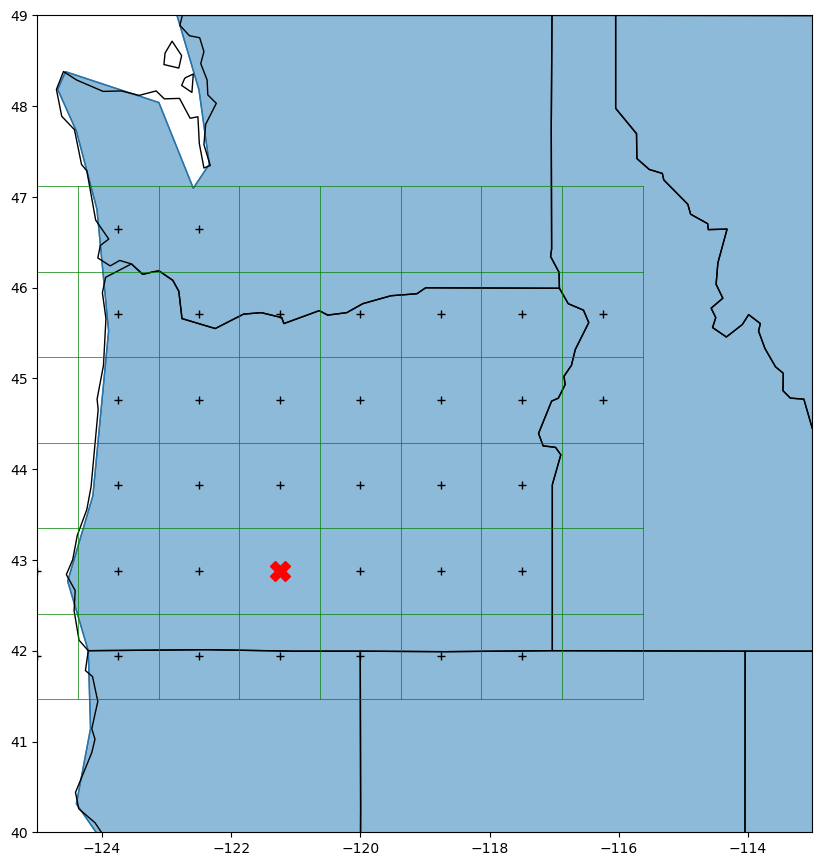

In [40]:
# Plot the USA states
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
usa_states.boundary.plot(ax=ax, linewidth=1)
usa_states.plot(ax=ax, alpha=0.5, edgecolor='k')
states.boundary.plot(ax=ax, linewidth=1, color='k', label='State Boundaries')

# bounding box in lat lon
bbox_lat_lon = [-124.0,41.0,-114.0,48.0]


# Plot latitudinal and longitudinal grid lines from the CMIP6 dataset
lon_offset = np.diff(cmip.lon.values)[0] / 2
lat_offset = np.diff(cmip.lat.values)[0] / 2

lons = [lo-lon_offset for lo in cmip.lon.values] + [cmip.lon.values[-1] + lon_offset]
lats = [la-lat_offset for la in cmip.lat.values] + [cmip.lat.values[-1] + lat_offset]

# add grid lines
for la in cmip.lat:
    ax.plot(lons, [la-lat_offset]*len(lons), color='green', linewidth=0.5)
ax.plot(lons, [la+lat_offset]*len(lons), color='green', linewidth=0.5)

for lo in lons:
    ax.plot([lo]*len(lats), lats, color='green', linewidth=0.5)

# determine where data exists (and doesn't exist) in the cmip dataset.
# TODO: combine this with the clip operation above.
from rasterio.features import geometry_mask
mask = geometry_mask(
    geom.geometry.values,
    transform=cmip.rio.transform(),
    invert=True,
    all_touched=True,
    out_shape=cmip.rio.shape)

# # add grid cell centroids
# # Only add the centroid if the value in the mask is True. This
# # way we're only showing locations where data exists in our cmip dataset.
for j in range(0, len(cmip.lat)):
    la = cmip.lat[j]
    for i in range(0, len(cmip.lon)):
        lo = cmip.lon[i]
        if mask[j][i]:
            ax.plot(lo, la, color='black', marker='+')
        
# adjust the figure axis to the extent of our study area
plt.xlim(bbox_lat_lon[0]-1, bbox_lat_lon[2]+1)
plt.ylim(bbox_lat_lon[1]-1, bbox_lat_lon[3]+1)

i = 3
j = 1
xlon = cmip.isel(lon=i).lon.item()
ylat = cmip.isel(lat=j).lat.item()
ax.plot(xlon, ylat, color='red', marker='X', markersize=14)

plt.show()

Find out which cells had the most rainfall throughout the our year of interest. The rainfall occurred from 11/1861 - 01/1862, so we'll select a range that captures this time period.

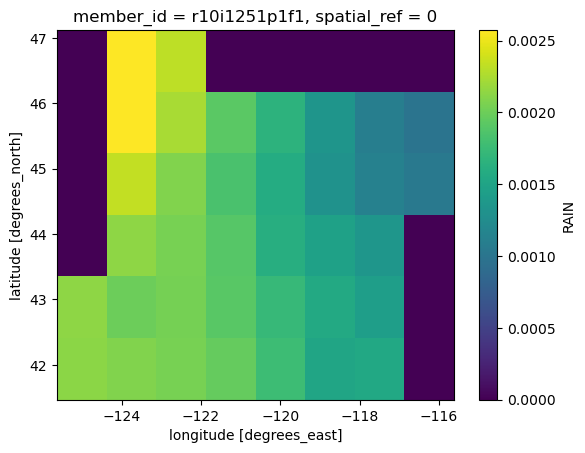

In [43]:
cmip_1862 = cmip.sel(time=slice('1861-01-01', '1863-01-01'))

# compute the sum of rainfall rates for each grid cell for the entire period of record.
cmip_1862.isel(member_id=1).RAIN.sum(dim='time').plot()

Plot the cumulative RAIN rate for each cell in our domain.

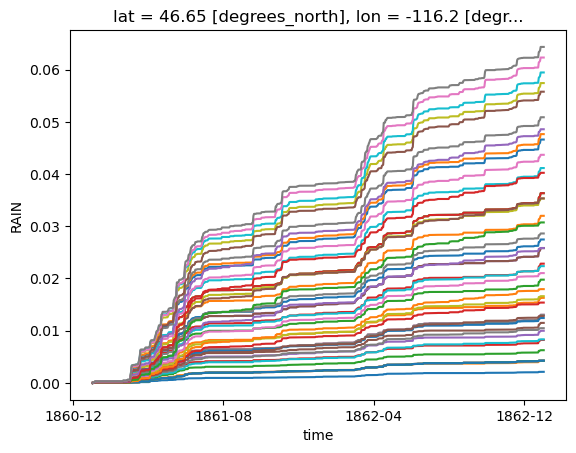

In [45]:
cmip_cumulative = cmip_1862.isel(member_id=1).RAIN.cumsum().compute()

fig, ax = plt.subplots()
for la in range(0, len(cmip_cumulative.lat)):
    for lo in range(0, len(cmip_cumulative.lon)):
        cmip_cumulative.isel(lat=la, lon=lo).plot(ax=ax)

## Compute Cumulative Rainfall for each Ensemble Member

Use a 45-day rolling window to compute total cumulative rainfall across our area of interest. See if any of these ensemble members capture the 1862 - 1863 atmospheric river storm.

In [27]:
# select an temporal range that is inclusive of the 1862 - 1863 event.
dat = cmip.sel(time=slice('1862-01-01', '1864-01-01'))

In [35]:
# calcuate 45-day rolling windows for the first 10 ensemble members
rolling_dict = helpers.compute_rolling_windows(dat, num_days=45, ensembles=range(0, 10), center=True)

# convert time variable to a pandas datetimeindex
for k, rolling_mem in rolling_dict.items():
    rolling_mem['time'] = rolling_mem.indexes['time'].to_datetimeindex()

Processing Member 0...done
Processing Member 1...done
Processing Member 2...done
Processing Member 3...done
Processing Member 4...done
Processing Member 5...done
Processing Member 6...done
Processing Member 7...done
Processing Member 8...done
Processing Member 9...done


/tmp/ipykernel_2060/426660071.py:6: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  rolling_mem['time'] = rolling_mem.indexes['time'].to_datetimeindex()


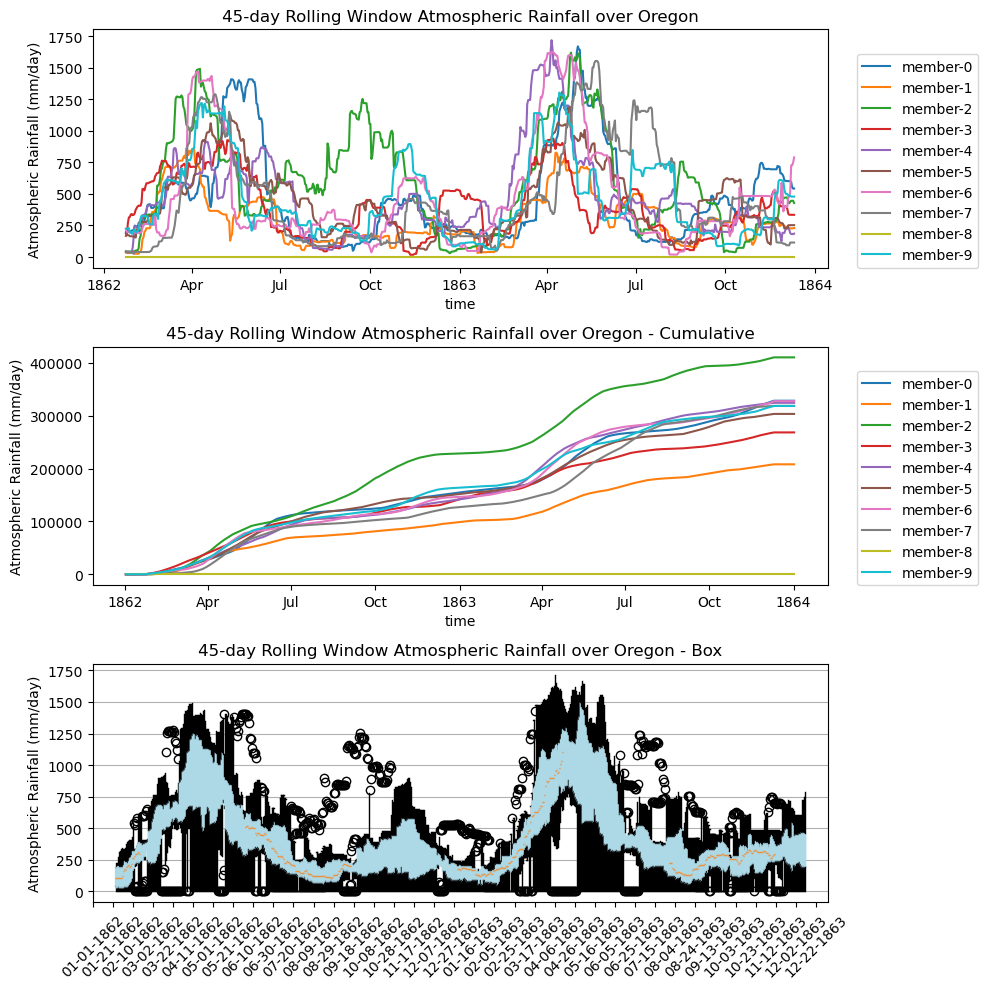

In [62]:
helpers.create_rolling_window_plots(rolling_dict,
                                   title='45-day Rolling Window Atmospheric Rainfall over Oregon',
                                   ylabel='Atmospheric Rainfall (mm/day)')

Do the same analysis for the next 10 ensemble member.

In [63]:
# select an temporal range that is inclusive of the 1862 - 1863 event.
dat = cmip.sel(time=slice('1862-01-01', '1864-01-01'))

# calcuate 45-day rolling windows for ensemble members 10 - 19
rolling_dict_10_19 = compute_rolling_windows(dat, num_days=45, ensembles=range(10, 20), center=True)

# convert time variable to a pandas datetimeindex
for k, rolling_mem in rolling_dict_10_19.items():
    rolling_mem['time'] = rolling_mem.indexes['time'].to_datetimeindex()

Processing Member 10...done
Processing Member 11...done
Processing Member 12...done
Processing Member 13...done
Processing Member 14...done
Processing Member 15...done
Processing Member 16...done
Processing Member 17...done
Processing Member 18...done
Processing Member 19...done


/tmp/ipykernel_2060/1045411504.py:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  rolling_mem['time'] = rolling_mem.indexes['time'].to_datetimeindex()


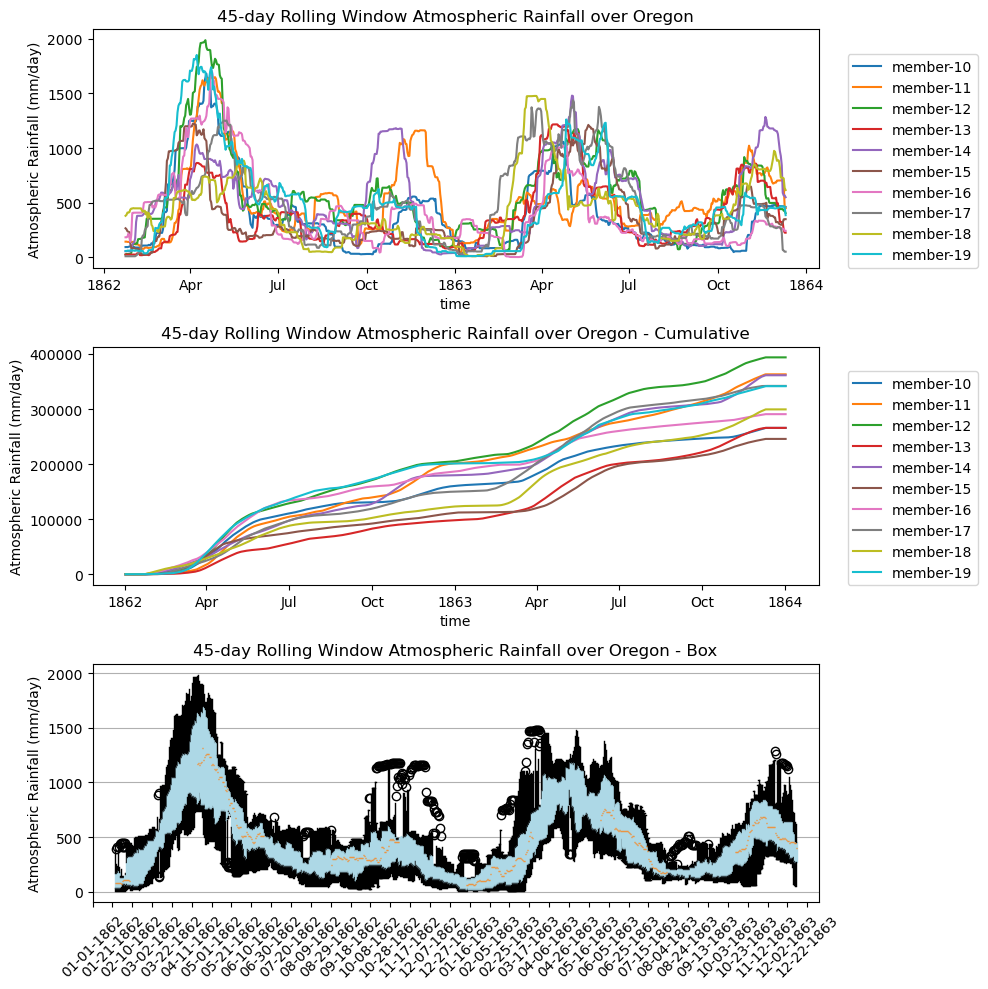

In [65]:
helpers.create_rolling_window_plots(rolling_dict_10_19,
                                    title='45-day Rolling Window Atmospheric Rainfall over Oregon',
                                    ylabel='Atmospheric Rainfall (mm/day)')

The Great Flood of 1862. It was the largest recorded flood in the history of California, Nevada, and Oregon. It occurred following several weeks of continuous **rain and snow that began in Oregon in November of 1861 and continued into January 1862**. These weather conditions contributed to flooding that spanned from the Columbia River in western Oregon to the city of San Diego, over 1,000 miles away, and also impacted a handful of interior states. 
